# Visualization

This notebook loads, preprocesses, and visualizes raw data from the given dataset, generated from the COMSOL simulations of a single-junction perovskite solar cell. See Zhao Xinhai's PhD thesis for more details on the generation.

Here, we will visualize a few current-voltage (I-V) curves from the dataset. _For interactive visualization, run the code as a Python script._

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler

Set where to load the data from, provide the path to the folder containing the text files.

In [2]:
DATA_DIR = "../dataset/Data_1k_sets/Data_1k_rng1/"

In [15]:
# Output: output in the form of current density, A/m^2
Output = np.loadtxt(DATA_DIR + 'iV_m.txt', delimiter=',')
# Input: 31 input parameters
Input = np.loadtxt(DATA_DIR + 'LHS_parameters_m.txt', delimiter=',')

# See MATLAB file for COMSOL sweep that defines the applied voltage range
Va = np.concatenate((np.arange(0, 0.41, 0.1), np.arange(0.425, 1.401, 0.025)))  # applied voltage, V

N = Output.shape[0]  # number of cases

Text(0, 0.5, 'Value')

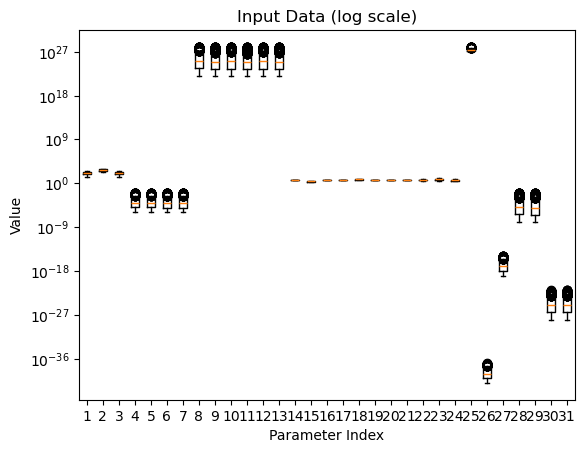

In [9]:
# Input data
plt.figure(4)
plt.boxplot(Input)
plt.yscale('log')
plt.title('Input Data (log scale)')
plt.xlabel('Parameter Index')
plt.ylabel('Value')

Text(0, 0.5, 'Current Density (A/m^2)')

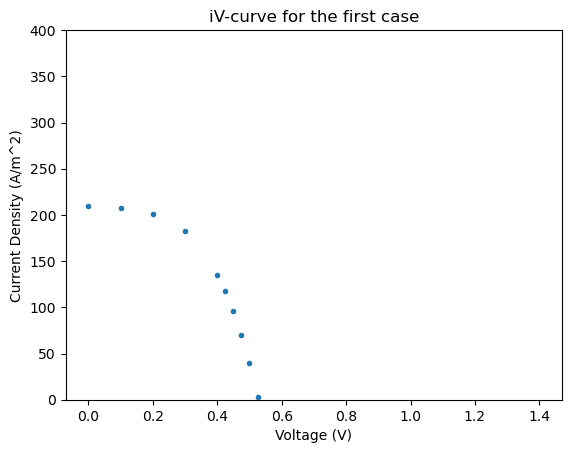

In [ ]:
# iV-curve for the first case
plt.figure(1)
plt.plot(Va, Output[200, :], '.')
plt.ylim([0, 400])
plt.title('iV-curve for the first case')
plt.xlabel('Voltage (V)')
plt.ylabel('Current Density (A/m^2)')

In [ ]:
# iV-curves for all cases
plt.figure(2)
for i in range(N):
    plt.plot(Va, Output[i, :], '.')
plt.ylim([-2000, 400])
plt.title('iV-curves for all cases')
plt.xlabel('Voltage (V)')
plt.ylabel('Current Density (A/m^2)')

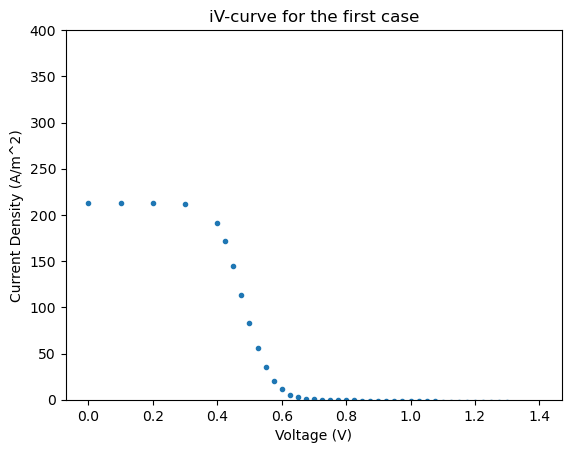

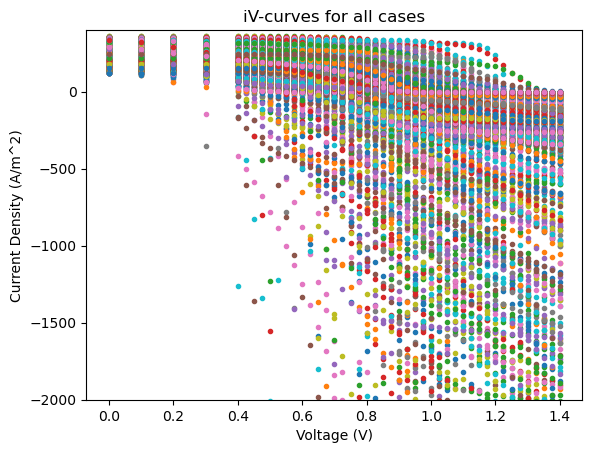

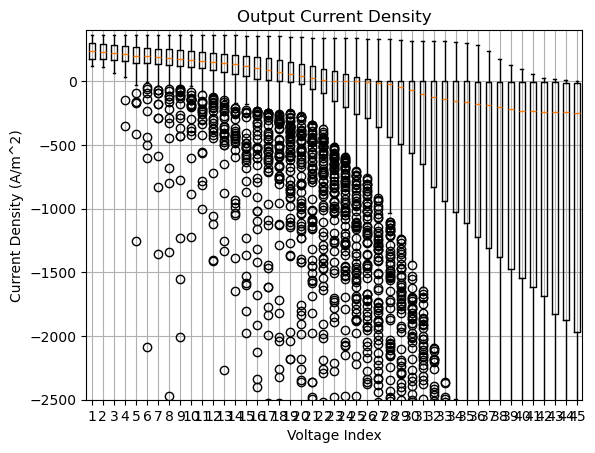

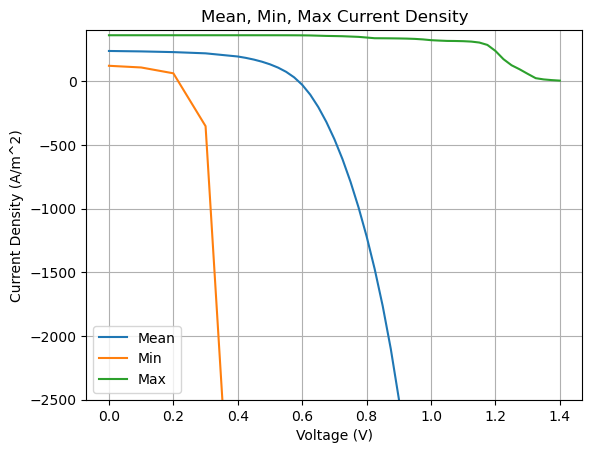

In [ ]:
# Output current density
plt.figure(3)
plt.boxplot(Output)
plt.ylim([-2500, 400])
plt.title('Output Current Density')
plt.xlabel('Voltage Index')
plt.ylabel('Current Density (A/m^2)')
plt.grid(True)

# Mean, max, min current density across all cases
plt.figure(5)
curr_den_mean = np.mean(Output, axis=0)
curr_den_max = np.max(Output, axis=0)
curr_den_min = np.min(Output, axis=0)
plt.plot(Va, curr_den_mean, label='Mean')
plt.plot(Va, curr_den_min, label='Min')
plt.plot(Va, curr_den_max, label='Max')
plt.ylim([-2500, 400])
plt.title('Mean, Min, Max Current Density')
plt.xlabel('Voltage (V)')
plt.ylabel('Current Density (A/m^2)')
plt.grid(True)
plt.legend()

plt.show()

## Features Scaling

It seems like we have some crazy ranges in the input features. We need to perform log scaling on some features and then robust scaling. Visualize the result:

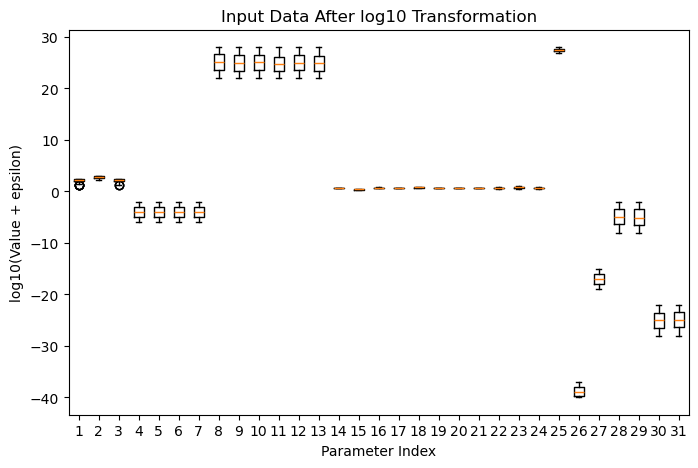

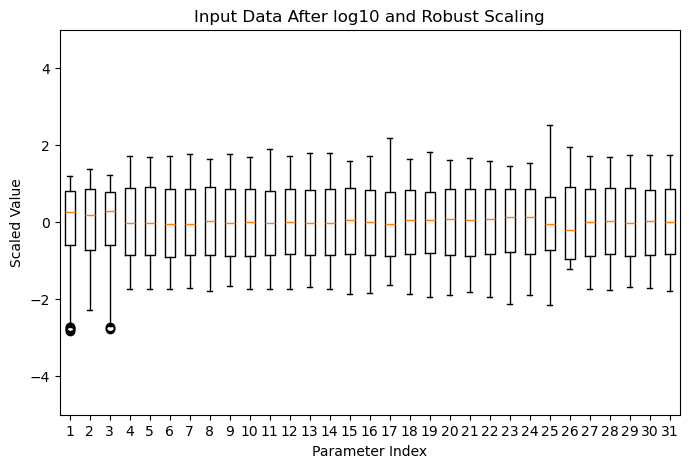


Shape of the final processed input data: (657, 31)
Example of values from the final processed data (first row):
[-1.0258768   0.15463187 -0.05158175  1.04882397  1.20397106]


In [7]:
# Step 1: Apply log10 transformation to handle vast dynamic range and skewedness
# Epsilon to handle zeros or extremely small positive numbers that might round to zero
epsilon = 1e-40
Input_log_transformed = np.log10(Input + epsilon)

# Verify the result of log transformation (should now be in a range like -40 to +30)
plt.figure(figsize=(8, 5))
plt.boxplot(Input_log_transformed)
plt.title('Input Data After log10 Transformation')
plt.xlabel('Parameter Index')
plt.ylabel('log10(Value + epsilon)')
plt.show()


# Step 2: Apply RobustScaler to the log-transformed data
# This will normalize the mean and scale within each parameter's distribution.
# This is crucial for ML models.
scaler = RobustScaler()
Input_final_scaled = scaler.fit_transform(Input_log_transformed)

# Verify the result of RobustScaler (should now be centered around 0 for most features)
plt.figure(figsize=(8, 5))
plt.boxplot(Input_final_scaled)
plt.title('Input Data After log10 and Robust Scaling')
plt.xlabel('Parameter Index')
plt.ylabel('Scaled Value')
# Set y-limits to see the scaling effect clearly
plt.ylim([-5, 5]) # Typically, scaled data will mostly fall in this range
plt.show()

print("\nShape of the final processed input data:", Input_final_scaled.shape)
print("Example of values from the final processed data (first row):")
print(Input_final_scaled[0, :5]) # Print first 5 features of the first sample

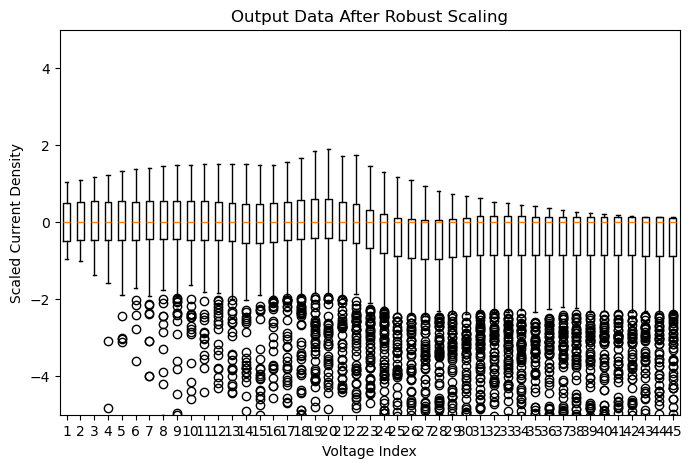

In [8]:
# Apply RobustScaler to the output (y_train)
output_scaler = RobustScaler()
y_train_scaled = output_scaler.fit_transform(Output)

# Plot the distribution after scaling
plt.figure(figsize=(8, 5))
plt.boxplot(y_train_scaled)
plt.title('Output Data After Robust Scaling')
plt.xlabel('Voltage Index')
plt.ylabel('Scaled Current Density')
plt.ylim([-5, 5])
plt.show()

Analyze the feature correlation, result: there pretty much no correlation between the features.

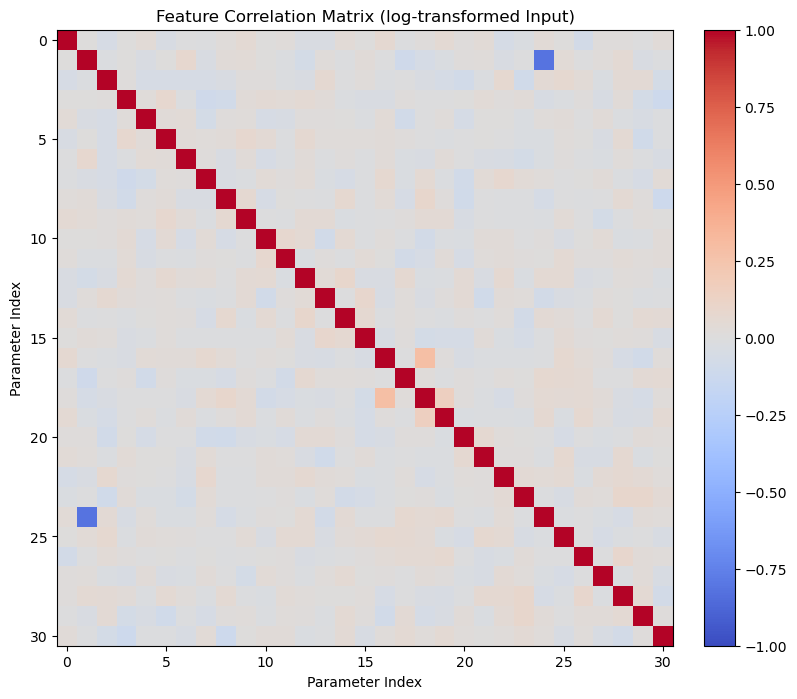

In [5]:
# Compute the correlation matrix for the original input data (log-transformed for better scaling)
corr_matrix = np.corrcoef(Input_log_transformed, rowvar=False)

plt.figure(figsize=(10, 8))
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Feature Correlation Matrix (log-transformed Input)')
plt.xlabel('Parameter Index')
plt.ylabel('Parameter Index')
plt.show()

## Filtering out negative current values

Now we realised that we do not need the negative part of the current values, we first need to filter this and check if all curves are monotonically decreasing (so we can enforce that physics loss).

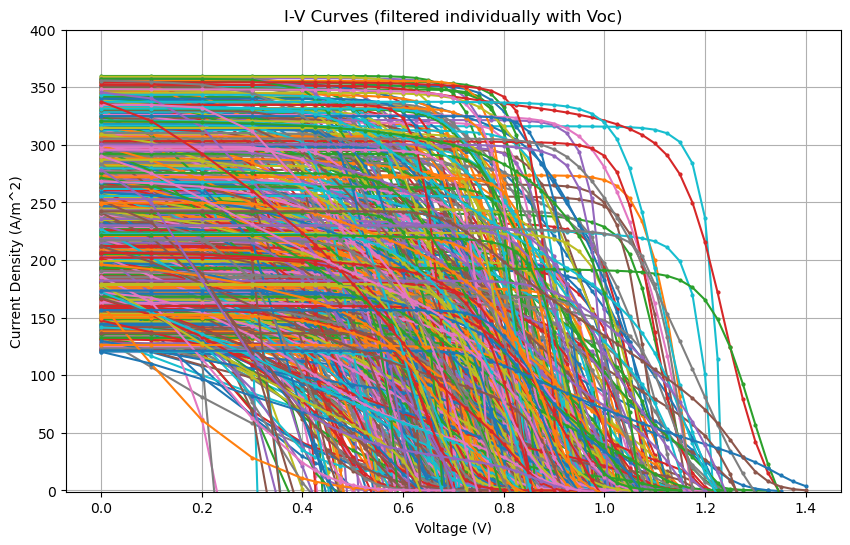

Number of points per sample: [18, 25, 18, 16, 23, 23, 31, 33, 20, 20, 26, 19, 25, 15, 28, 19, 24, 23, 29, 24, 18, 15, 32, 25, 21, 23, 16, 21, 21, 24, 10, 33, 26, 8, 23, 30, 24, 31, 26, 16, 33, 38, 5, 26, 20, 18, 14, 42, 17, 39, 34, 28, 28, 34, 14, 20, 28, 9, 8, 30, 37, 17, 7, 33, 22, 27, 7, 19, 15, 26, 14, 35, 30, 23, 18, 25, 19, 28, 31, 16, 21, 21, 27, 34, 24, 36, 16, 26, 30, 24, 7, 30, 42, 27, 32, 22, 25, 35, 6, 15, 11, 14, 37, 17, 24, 16, 26, 17, 8, 38, 25, 14, 27, 19, 15, 17, 21, 21, 12, 20, 24, 16, 8, 19, 26, 15, 25, 25, 31, 24, 43, 24, 33, 14, 13, 23, 10, 22, 12, 27, 39, 20, 27, 26, 16, 27, 23, 29, 28, 27, 32, 36, 24, 17, 34, 21, 28, 36, 22, 29, 39, 27, 18, 17, 32, 25, 19, 29, 22, 24, 8, 34, 19, 22, 21, 25, 24, 15, 30, 34, 25, 31, 32, 36, 9, 40, 29, 20, 12, 28, 17, 28, 22, 18, 24, 27, 15, 20, 23, 28, 21, 28, 22, 23, 29, 20, 26, 18, 29, 17, 21, 34, 26, 29, 27, 16, 26, 28, 20, 38, 19, 22, 21, 28, 26, 34, 29, 27, 32, 15, 20, 21, 30, 29, 32, 15, 31, 28, 24, 31, 19, 20, 15, 25, 12, 38

In [ ]:
filtered_curves = []
points_per_sample = []

for i in range(N):
    sample = Output[i, :]
    # Find the index of the first negative value in this sample
    neg_indices = np.where(sample < 0)[0]
    if len(neg_indices) > 0:
        first_neg = neg_indices[0]
        idx = np.arange(first_neg + 1)  # include the first negative point
    else:
        idx = np.arange(len(Va))
    filtered_curves.append((Va[idx], sample[idx]))
    points_per_sample.append(len(idx))

plt.figure(figsize=(10, 6))
for Va_sample, current_sample in filtered_curves:
    plt.plot(Va_sample, current_sample, '.-', markersize=4)
plt.title('I-V Curves (filtered individually with Voc)')
plt.xlabel('Voltage (V)')
plt.ylabel('Current Density (A/m^2)')
plt.ylim(bottom=min(current_sample.min(), 0), top=400)
plt.grid(True)
plt.show()

print("Number of points per sample:", points_per_sample)
print("Max number of points in a sample:", max(points_per_sample))
print("Min number of points in a sample:", min(points_per_sample))

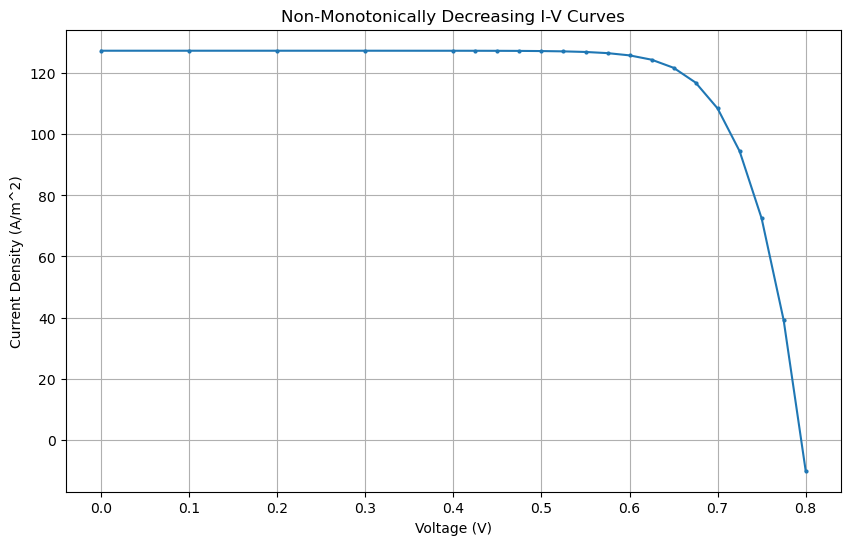

Number of non-monotonically decreasing curves: 1


In [19]:
# Identify and plot non-monotonically decreasing curves
plt.figure(figsize=(10, 6))
non_monotonic_curves = []

for Va_sample, current_sample in filtered_curves:
    if not np.all(np.diff(current_sample) <= 0):
        non_monotonic_curves.append((Va_sample, current_sample))
        plt.plot(Va_sample, current_sample, '.-', markersize=4)

plt.title('Non-Monotonically Decreasing I-V Curves')
plt.xlabel('Voltage (V)')
plt.ylabel('Current Density (A/m^2)')
plt.grid(True)
plt.show()

print(f"Number of non-monotonically decreasing curves: {len(non_monotonic_curves)}")


### Methods to adapt the model to the new sequence data

- Padding
- Interpolate / exterpolate (bad idea?)
- Switch to sequence tasks (some can combine with generative tasks)

Approach one: fix the number of points, but need two steps
- Input parameters
- First predict V_oc
- Then reconstruct the voltage axis np.linspace(0, predicted V_oc, num_points)
- THEN predict the current values at these voltages for fixed num_points
- The output IV curve is (target_v_points, predicted_current_values)

Approach two: use a sequence model, generates a sequence of (V, I) pairs, one step at a time, decides when to stop by a special token.

Approach three: still keep our existing models, but preprocess the data to pad the IV curves to fixed length with zeros and create a mask to ignore them during loss calculation. **THIS IS NOT VALIDATED TO WORK YET!**